In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import warnings
from lock_key_env import LockKeyEnv  # make sure this matches your file name

# Optional: Inline plotting
%matplotlib inline


c:\Users\renza\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
def train_curriculum(
    phase_schedule,
    episodes_per_phase,
    save_path="lockkey_unified.pkl",
    base_alpha=0.9,
    base_gamma=0.9,
    epsilon_start=1.0,
    base_epsilon_decay=1e-4,
    per_phase_hparams=None,
    seed=None,
    render_eval=False,
    max_steps_per_episode=200
):
    rng = np.random.default_rng(seed)

    # Instantiate environment to get state/action sizes
    env = LockKeyEnv(render_mode=None, size=6, phase=1, seed=seed)
    obs_n = env.observation_space.n
    act_n = env.action_space.n

    # Initialize unified Q-table
    q = np.zeros((obs_n, act_n), dtype=float)

    # Normalize episodes_per_phase to list
    if isinstance(episodes_per_phase, int):
        episodes_per_phase = [episodes_per_phase] * len(phase_schedule)
    assert len(episodes_per_phase) == len(phase_schedule), "episodes_per_phase length mismatch"

    if per_phase_hparams is None:
        per_phase_hparams = {}

    epsilon = epsilon_start
    alpha = base_alpha
    gamma = base_gamma
    base_eps_decay = base_epsilon_decay

    total_episode_counter = 0
    rewards_history = []

    print("Starting curriculum training. Phases:", phase_schedule)

    for idx, phase in enumerate(phase_schedule):
        # Per-phase overrides
        phase_episodes = episodes_per_phase[idx]
        phase_hp = per_phase_hparams.get(phase, {})
        phase_alpha = phase_hp.get("alpha", base_alpha)
        phase_epsilon_decay = phase_hp.get("epsilon_decay", base_eps_decay)
        phase_episodes = phase_hp.get("episodes", phase_episodes)
        epsilon = phase_hp.get("epsilon_start", 1.0)

        # Skip unsupported Phase 5
        if phase == 5:
            try:
                env.phase = 5
                _ = env.reset()
            except Exception:
                warnings.warn("Phase 5 not supported by environment. Skipping.")
                continue

        env.phase = phase
        print(f"\n--- Phase {phase} training: {phase_episodes} episodes | alpha={phase_alpha} | eps_decay={phase_epsilon_decay} ---")

        phase_rewards = []

        for ep in range(phase_episodes):
            total_episode_counter += 1
            env.current_episode = total_episode_counter
            state, _ = env.reset()
            terminated = False
            truncated = False
            ep_reward = 0
            step_count = 0

            while not terminated and not truncated and step_count < max_steps_per_episode:
                if rng.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = int(np.argmax(q[state, :]))

                new_state, reward, terminated, truncated, _ = env.step(action)
                ep_reward += reward
                q[state, action] += phase_alpha * (reward + gamma * np.max(q[new_state, :]) - q[state, action])
                state = new_state
                step_count += 1

            epsilon = max(0.0, epsilon - phase_epsilon_decay)
            rewards_history.append(ep_reward)
            phase_rewards.append(ep_reward)

            if total_episode_counter % 500 == 0:
                avg100 = np.mean(rewards_history[max(0, len(rewards_history)-100):])
                print(f"Episode {total_episode_counter} | Phase {phase} | Epsilon: {epsilon:.4f} | AvgReward(100): {avg100:.2f}")

        # Plot rewards after each phase
        plt.figure(figsize=(8,5))
        plt.plot(phase_rewards, label=f"Phase {phase} Reward")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title(f"Lock & Key Rewards: Phase {phase}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Save Q-table
    with open(save_path, "wb") as f:
        pickle.dump(q, f)
    print(f"\n✅ Training complete. Q-table saved to {save_path}")

    # Plot overall rewards
    plt.figure(figsize=(9, 5))
    plt.plot(rewards_history, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Reward per Episode (curriculum)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional short evaluation
    print("\n--- Running short evaluation (rendering optional) ---")
    evaluate(save_path, episodes=10, render=render_eval, phase=3)

    return q


In [3]:
def evaluate(q_path, episodes=5, render=True, phase=3, seed=None, max_steps=200):
    if not os.path.exists(q_path):
        raise FileNotFoundError(f"Q-table not found: {q_path}")

    with open(q_path, "rb") as f:
        q = pickle.load(f)

    env = LockKeyEnv(render_mode='human' if render else None, size=6, phase=phase, seed=seed)

    try:
        _ = env.reset()
    except Exception as e:
        print(f"Environment reset failed for phase {phase}: {e}")
        env.close()
        return []

    success_count = 0
    total_rewards = []

    for ep in range(episodes):
        env.current_episode = ep + 1
        state, _ = env.reset()
        terminated = False
        truncated = False
        ep_reward = 0
        step_count = 0

        while not terminated and not truncated and step_count < max_steps:
            action = int(np.argmax(q[state, :]))
            new_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            state = new_state
            step_count += 1

            if render:
                env.render()

        total_rewards.append(ep_reward)
        if terminated:
            success_count += 1

    env.close()
    print(f"Evaluation | Phase {phase} | Episodes {episodes} | Successes: {success_count}/{episodes} | AvgReward: {np.mean(total_rewards):.2f}")
    return total_rewards


In [4]:
PHASE_SCHEDULE = [1, 2, 3, 4, 5]   # include 5 but script will skip if env lacks support
EPISODES_PER_PHASE = [15000, 10000, 10000, 5000, 5000]  # sample counts; tune as needed

    # Per-phase hyperparameter tweaks (especially Phase 4 to stabilize)
PER_PHASE_HPARAMS = {
    1: {"alpha": 0.9, "epsilon_decay": 1e-4, "episodes": EPISODES_PER_PHASE[0], "epsilon_start": 1.0},
    2: {"alpha": 0.85, "epsilon_decay": 8e-5, "episodes": EPISODES_PER_PHASE[1], "epsilon_start": 0.9},
    3: {"alpha": 0.8, "epsilon_decay": 5e-5, "episodes": EPISODES_PER_PHASE[2], "epsilon_start": 0.8},
    4: {"alpha": 0.15, "epsilon_decay": 1e-5, "episodes": EPISODES_PER_PHASE[3], "epsilon_start": 0.5},
    5: {"alpha": 0.1, "epsilon_decay": 5e-5, "episodes": EPISODES_PER_PHASE[4], "epsilon_start": 0.8},  # Phase 5: harder
}

SAVE_PATH = "lockkey_unified.pkl"


Starting curriculum training. Phases: [1, 2, 3, 4, 5]

--- Phase 1 training: 15000 episodes | alpha=0.9 | eps_decay=0.0001 ---
Episode 500 | Phase 1 | Epsilon: 0.9500 | AvgReward(100): -565.26
Episode 1000 | Phase 1 | Epsilon: 0.9000 | AvgReward(100): -356.27
Episode 1500 | Phase 1 | Epsilon: 0.8500 | AvgReward(100): -225.17
Episode 2000 | Phase 1 | Epsilon: 0.8000 | AvgReward(100): -156.50
Episode 2500 | Phase 1 | Epsilon: 0.7500 | AvgReward(100): -118.73
Episode 3000 | Phase 1 | Epsilon: 0.7000 | AvgReward(100): -90.43
Episode 3500 | Phase 1 | Epsilon: 0.6500 | AvgReward(100): -57.55
Episode 4000 | Phase 1 | Epsilon: 0.6000 | AvgReward(100): -47.99
Episode 4500 | Phase 1 | Epsilon: 0.5500 | AvgReward(100): -29.85
Episode 5000 | Phase 1 | Epsilon: 0.5000 | AvgReward(100): -23.64
Episode 5500 | Phase 1 | Epsilon: 0.4500 | AvgReward(100): -13.61
Episode 6000 | Phase 1 | Epsilon: 0.4000 | AvgReward(100): -10.17
Episode 6500 | Phase 1 | Epsilon: 0.3500 | AvgReward(100): -5.99
Episode 7000

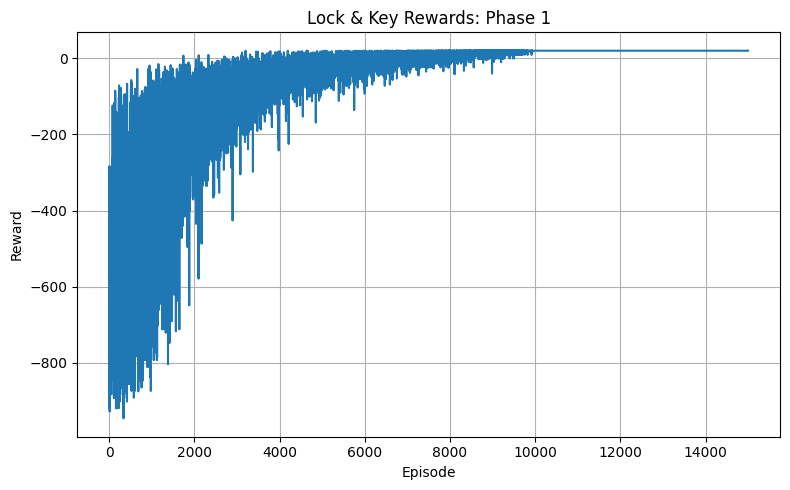


--- Phase 2 training: 10000 episodes | alpha=0.85 | eps_decay=8e-05 ---
Episode 15500 | Phase 2 | Epsilon: 0.8600 | AvgReward(100): -334.60
Episode 16000 | Phase 2 | Epsilon: 0.8200 | AvgReward(100): -217.04
Episode 16500 | Phase 2 | Epsilon: 0.7800 | AvgReward(100): -151.05
Episode 17000 | Phase 2 | Epsilon: 0.7400 | AvgReward(100): -120.66
Episode 17500 | Phase 2 | Epsilon: 0.7000 | AvgReward(100): -101.58
Episode 18000 | Phase 2 | Epsilon: 0.6600 | AvgReward(100): -66.97
Episode 18500 | Phase 2 | Epsilon: 0.6200 | AvgReward(100): -56.36
Episode 19000 | Phase 2 | Epsilon: 0.5800 | AvgReward(100): -46.60
Episode 19500 | Phase 2 | Epsilon: 0.5400 | AvgReward(100): -36.03
Episode 20000 | Phase 2 | Epsilon: 0.5000 | AvgReward(100): -27.75
Episode 20500 | Phase 2 | Epsilon: 0.4600 | AvgReward(100): -19.80
Episode 21000 | Phase 2 | Epsilon: 0.4200 | AvgReward(100): -15.03
Episode 21500 | Phase 2 | Epsilon: 0.3800 | AvgReward(100): -7.86
Episode 22000 | Phase 2 | Epsilon: 0.3400 | AvgRewar

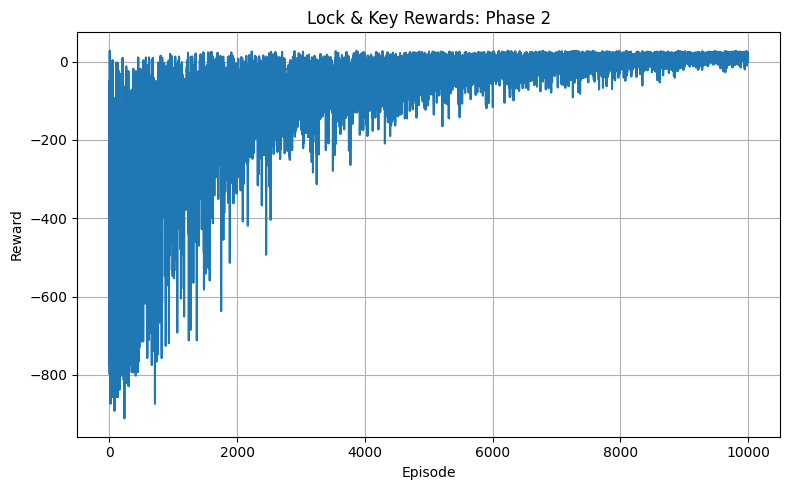


--- Phase 3 training: 10000 episodes | alpha=0.8 | eps_decay=5e-05 ---
Episode 25500 | Phase 3 | Epsilon: 0.7750 | AvgReward(100): -535.89
Episode 26000 | Phase 3 | Epsilon: 0.7500 | AvgReward(100): -506.45
Episode 26500 | Phase 3 | Epsilon: 0.7250 | AvgReward(100): -462.81
Episode 27000 | Phase 3 | Epsilon: 0.7000 | AvgReward(100): -411.90
Episode 27500 | Phase 3 | Epsilon: 0.6750 | AvgReward(100): -401.26
Episode 28000 | Phase 3 | Epsilon: 0.6500 | AvgReward(100): -356.22
Episode 28500 | Phase 3 | Epsilon: 0.6250 | AvgReward(100): -327.92
Episode 29000 | Phase 3 | Epsilon: 0.6000 | AvgReward(100): -303.99
Episode 29500 | Phase 3 | Epsilon: 0.5750 | AvgReward(100): -282.58
Episode 30000 | Phase 3 | Epsilon: 0.5500 | AvgReward(100): -247.78
Episode 30500 | Phase 3 | Epsilon: 0.5250 | AvgReward(100): -166.51
Episode 31000 | Phase 3 | Epsilon: 0.5000 | AvgReward(100): -169.95
Episode 31500 | Phase 3 | Epsilon: 0.4750 | AvgReward(100): -139.54
Episode 32000 | Phase 3 | Epsilon: 0.4500 | 

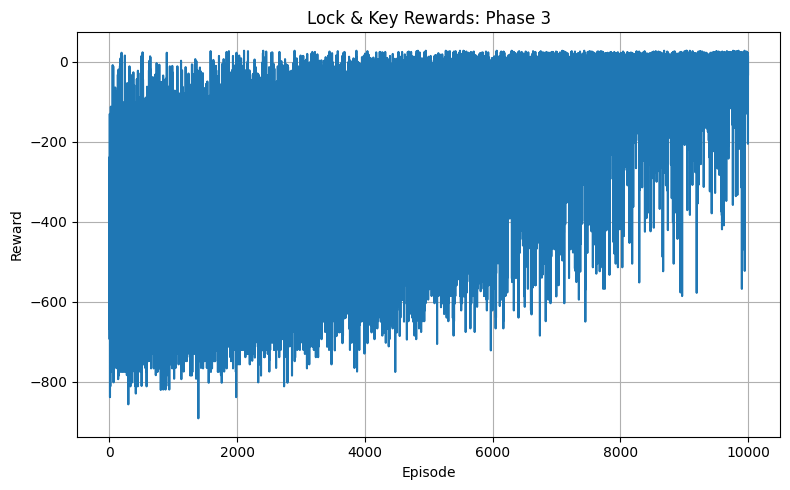


--- Phase 4 training: 5000 episodes | alpha=0.15 | eps_decay=1e-05 ---
Episode 35500 | Phase 4 | Epsilon: 0.4950 | AvgReward(100): -95.68
Episode 36000 | Phase 4 | Epsilon: 0.4900 | AvgReward(100): -101.11
Episode 36500 | Phase 4 | Epsilon: 0.4850 | AvgReward(100): -96.92
Episode 37000 | Phase 4 | Epsilon: 0.4800 | AvgReward(100): -83.31
Episode 37500 | Phase 4 | Epsilon: 0.4750 | AvgReward(100): -59.23
Episode 38000 | Phase 4 | Epsilon: 0.4700 | AvgReward(100): -72.92
Episode 38500 | Phase 4 | Epsilon: 0.4650 | AvgReward(100): -65.00
Episode 39000 | Phase 4 | Epsilon: 0.4600 | AvgReward(100): -51.41
Episode 39500 | Phase 4 | Epsilon: 0.4550 | AvgReward(100): -54.32
Episode 40000 | Phase 4 | Epsilon: 0.4500 | AvgReward(100): -53.12


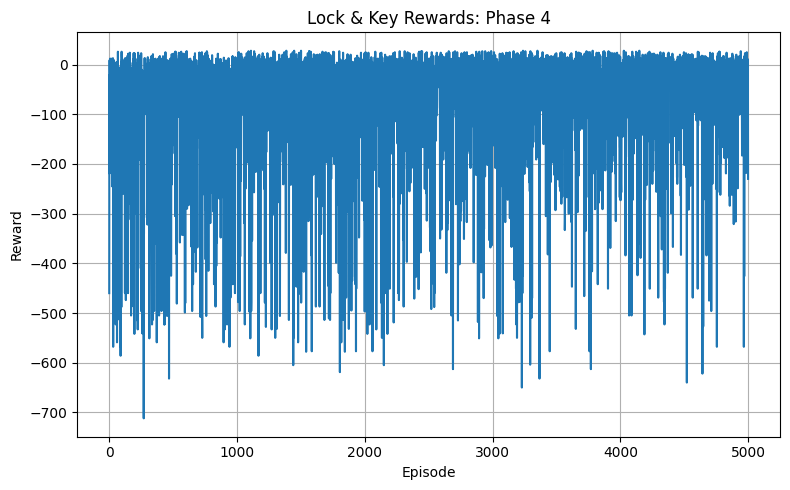


--- Phase 5 training: 5000 episodes | alpha=0.1 | eps_decay=5e-05 ---
Episode 40500 | Phase 5 | Epsilon: 0.7750 | AvgReward(100): -131.48
Episode 41000 | Phase 5 | Epsilon: 0.7500 | AvgReward(100): -121.73
Episode 41500 | Phase 5 | Epsilon: 0.7250 | AvgReward(100): -93.41
Episode 42000 | Phase 5 | Epsilon: 0.7000 | AvgReward(100): -84.08
Episode 42500 | Phase 5 | Epsilon: 0.6750 | AvgReward(100): -89.35
Episode 43000 | Phase 5 | Epsilon: 0.6500 | AvgReward(100): -89.19
Episode 43500 | Phase 5 | Epsilon: 0.6250 | AvgReward(100): -78.47
Episode 44000 | Phase 5 | Epsilon: 0.6000 | AvgReward(100): -72.36
Episode 44500 | Phase 5 | Epsilon: 0.5750 | AvgReward(100): -52.82
Episode 45000 | Phase 5 | Epsilon: 0.5500 | AvgReward(100): -56.29


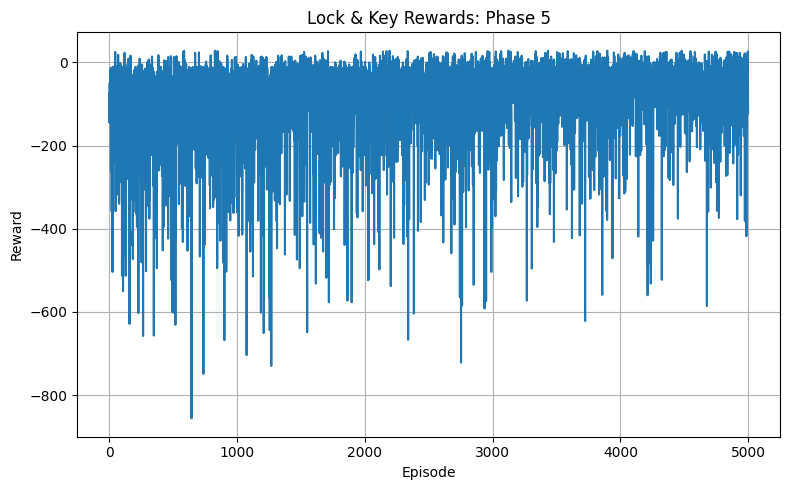


✅ Training complete. Q-table saved to lockkey_unified.pkl


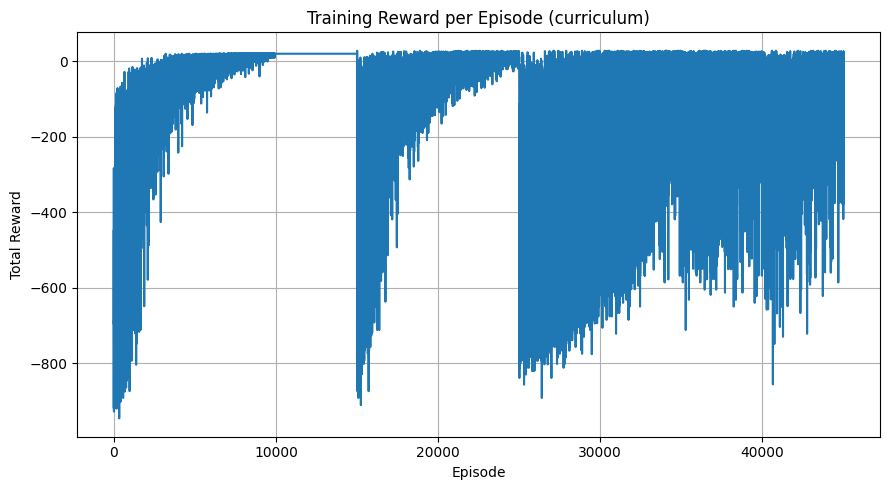


--- Running short evaluation (rendering optional) ---
Evaluation | Phase 3 | Episodes 10 | Successes: 5/10 | AvgReward: -88.50


In [5]:
q_table = train_curriculum(
    phase_schedule=PHASE_SCHEDULE,
    episodes_per_phase=EPISODES_PER_PHASE,
    save_path=SAVE_PATH,
    base_alpha=0.9,
    base_gamma=0.9,
    epsilon_start=1.0,
    base_epsilon_decay=1e-4,
    per_phase_hparams=PER_PHASE_HPARAMS,
    seed=None,
    render_eval=False
)


In [ ]:
while True:
    choice = input("\nEnter a phase to run evaluation (1-5), or 'q' to quit: ").strip().lower()
    if choice == 'q':
        print("Quitting.")
        break
    if choice not in ['1', '2', '3', '4', '5']:
        print("Invalid input; enter 1,2,3,4,5 or q.")
        continue

    phase_to_eval = int(choice)
    episodes_to_eval = input("How many episodes to run? (default 5): ").strip()
    try:
        episodes_to_eval = int(episodes_to_eval)
    except:
        episodes_to_eval = 5

    render_choice = input("Render? (y/n, default y): ").strip().lower()
    render_flag = (render_choice in ['', 'y', 'yes'])

    # Skip Phase 5 if unsupported
    if phase_to_eval == 5:
        try:
            tmp_env = LockKeyEnv(render_mode=None, size=6, phase=5)
            tmp_env.reset()
            tmp_env.close()
        except Exception:
            print("Phase 5 (enemy) not supported. Skipping.")
            continue

    evaluate(SAVE_PATH, episodes=episodes_to_eval, render=render_flag, phase=phase_to_eval)
